In [356]:
import networkx as nx
import numpy as np
log = True

In [357]:
def get_neighbor_opinion_distribution(G, node, exclude = None):
    """
    Return bin count of the opinions of the neighbors
    """ 
    count = {}
    for neigh in nx.neighbors(G, node):
        opinion = G.nodes[neigh]['opinion']
        if opinion != exclude:
            count[opinion] = count.get(opinion, 0) + 1
    return count

In [358]:
def get_majority_opinion(G, node):
    """
    Calculate the majority opinion of the nodes, i.e., the opinion held by the largest 
    number of individuals among the neighbors of the node. Possibly returns the node's current 
    opinion if that is the majority opinion among its neighbors
    """
    count = get_neighbor_opinion_distribution(G, node)
    maj_opinion = G.nodes[node]['opinion']
    max_count = count[maj_opinion]
    for o, c in count.items():
        if c > max_count:
            maj_opinion = o
            max_count = c  
    return maj_opinion        

In [359]:
def rewire(G, node, phi):
    """ 
    Disconnect node from a neighbor according to MA rule and connect him with probability phi
    to a random neighbor of its neighbors who holds the same
    opinion, or otherwise to a random one selected from the
    whole population except its nearest neighbors with probability 1-phi.
    """
    node_opinion = G.nodes[node]['opinion']
    count = get_neighbor_opinion_distribution(G, node, exclude = node_opinion)
    if not count:
        return 1
    min_opinion_count = min(count.values()) 
    candidate_removal_nodes = [ neigh for neigh in nx.neighbors(G, node) if 
                                G.nodes[neigh]['opinion'] != node_opinion and
                                count[G.nodes[neigh]['opinion']] == min_opinion_count and
                                G.degree[neigh] > 1
                               ]
    if not candidate_removal_nodes:
        return 2
    neigh_remove = np.random.choice(candidate_removal_nodes)
    neigh_add = None
    rule = np.random.binomial(1, phi)
    # rewire to neighbor of neighbors with same opinion
    if rule == 1:
        neighbor_of_neighbors = { neigh_of_neigh 
                                for neigh in nx.neighbors(G, node) 
                                for neigh_of_neigh in nx.neighbors(G, neigh) 
                                if G.nodes[neigh_of_neigh]['opinion'] == node_opinion
                                }
        neighbor_of_neighbors.remove(node)
        neighbor_of_neighbors -= set(nx.neighbors(G, node))
        if not neighbor_of_neighbors:
            return 3
        neigh_add = np.random.choice(np.fromiter(neighbor_of_neighbors, int, len(neighbor_of_neighbors))) 
    # rewire to any non-neighboring node in the network with same opinion
    elif rule == 0:
        candidates = { other_node 
                       for other_node in nx.nodes(G)
                       if G.nodes[other_node]['opinion'] == node_opinion
                    }   
        candidates.remove(node)
        candidates -= set(nx.neighbors(G, node))
        if not candidates:
            return 4
        neigh_add = np.random.choice(np.fromiter(candidates, int, len(candidates)))
    G.remove_edge(node, neigh_remove)    
    G.add_edge(node, neigh_add)
    if not nx.is_connected(G):
        # undo removal and addition of neighbors if it results in a disconnected graph
        G.remove_edge(node, neigh_add)    
        G.add_edge(node, neigh_remove)
        return 5
    if log:
        print('MA for node {} -> rule:{}, neigh_removed:{}, neigh_added:{}'
              .format(node, rule, neigh_remove, neigh_add))
    return 0

In [360]:
class Simulation:
    def __init__(self, N=15, avg_degree=5, p=0.5, phi=0.5, G=3):
        self.N = N
        self.k = avg_degree
        self.p = p
        self.phi = phi
        self.G = G
        self.time = 0
        self.stall = 0
        self.stall_bin = {}
        self.graph = nx.gnp_random_graph(N, avg_degree/N)
        self.status = 0
        # Guarantee initial graph is connected
        i = 0
        while(not nx.is_connected(self.graph)):
            if i == 5:
                raise RuntimeError("Couldn't generate connected random graph.")
            else:   
               self.graph = nx.gnp_random_graph(N, avg_degree/N)
               i += 1            
        self.init_opinions()
    def init_opinions(self):
        """ 
        Set the opinion of all individuals in the graph. 
        All opinions are equally likely (uniform distribution).
        """
        opinions = {i: np.random.choice(self.G) for i in range(self.N)}
        nx.set_node_attributes(self.graph, opinions, 'opinion')
    def step(self):
        """ 
        One step of the simulation. Application of one of the rules (MA or MP) to a single node. 
        """
        # choose between MA and MP according to the parameter p
        rule = np.random.binomial(1, self.p)
        # choose a random node to apply the rule to
        node = np.random.choice(nx.nodes(self.graph))
        stall_code = 0
        # rule==1 -> Apply majority preference rule to node
        if rule == 1:
            maj_opinion = get_majority_opinion(self.graph, node)
            if log:    
                prev_opinion = self.graph.nodes[node]['opinion']
                print('MP for node {} -> prev_opinion:{}, curr_opinion:{}'.format(node, prev_opinion, maj_opinion))
            self.graph.nodes[node]['opinion'] = maj_opinion
        # rule==0 -> Apply minority avoidance rule to node
        else:  
           stall_code = rewire(self.graph, node, self.phi) 
        if not stall_code:
            self.time += 1
        # error_code 1 means the node doesn't have neighbors with an opinion different than his
        # so it's no problem since it just means the node converged already
        elif stall_code != 1:
            self.stall += 1
            self.stall_bin[stall_code] = self.stall_bin.get(stall_code, 0) + 1
    def stop_condition(self):
        """
        When we reach the consensus state we can stop the simulation, i.e., when each individuals
        opinion agrees with the majority of its neighbors.
        """
        def agrees_with_majority(node):
            count = get_neighbor_opinion_distribution(self.graph, node)
            max_opinion_count = max(count.values()) 
            return count.get(self.graph.nodes[node]['opinion'], 0) == max_opinion_count
        return all(
                agrees_with_majority(node)
                for node in nx.nodes(self.graph)
             )
    def loop_condition(self):
        """
        Condition to stop the simulation run due to possible loop.
        Here we expect more stalls with more nodes, less connectedness and
        larger phi (for simplicity's sake we ignore phi).
        If there are too many stalls for each advance in the simulation we
        consider the simulation is probably looping. 
        """
        return self.stall >= 20 + 3 * self.time * np.log2(self.N) / self.k
    def run(self):
        if self.status:
            return self.status
        while(not self.stop_condition()):
            self.step()
            if self.loop_condition():
                self.status = -1
                return 1
        self.status = 1    
        return 0

In [361]:
def draw(G):
    nx.draw(G, with_labels= True, node_color=list(nx.get_node_attributes(G, "opinion").values()))

[(0, 14), (1, 2), (1, 3), (1, 5), (1, 14), (2, 3), (2, 5), (2, 11), (3, 12), (4, 8), (4, 9), (4, 11), (5, 6), (5, 7), (5, 8), (5, 13), (6, 7), (6, 13), (7, 9), (8, 11), (8, 14), (9, 13), (9, 14), (10, 11), (10, 14)]
{0: 1, 1: 2, 2: 0, 3: 0, 4: 2, 5: 0, 6: 2, 7: 2, 8: 1, 9: 2, 10: 2, 11: 1, 12: 2, 13: 1, 14: 1}


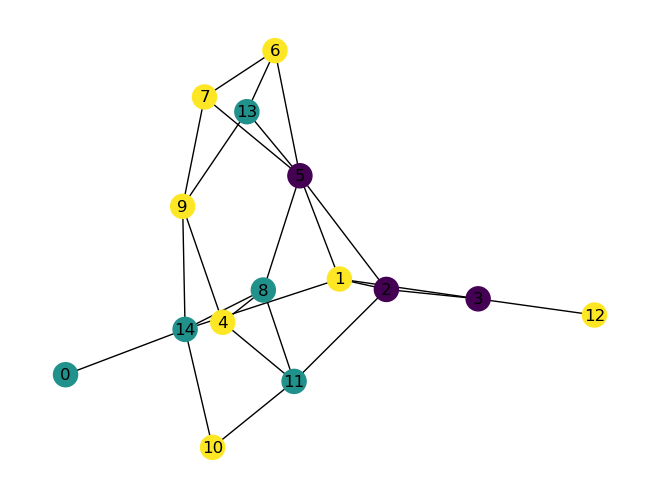

In [362]:
simul = Simulation(N = 15, avg_degree = 4, p = 0.1)
G = simul.graph
print(simul.graph.edges)
print(nx.get_node_attributes(G, "opinion"))
draw(G)

MA for node 13 -> rule:1, neigh_removed:5, neigh_added:8
MA for node 10 -> rule:0, neigh_removed:11, neigh_added:9
MA for node 3 -> rule:1, neigh_removed:1, neigh_added:5
MA for node 11 -> rule:1, neigh_removed:4, neigh_added:13
{0: 1, 1: 2, 2: 0, 3: 0, 4: 2, 5: 0, 6: 2, 7: 2, 8: 1, 9: 2, 10: 2, 11: 1, 12: 2, 13: 1, 14: 1}


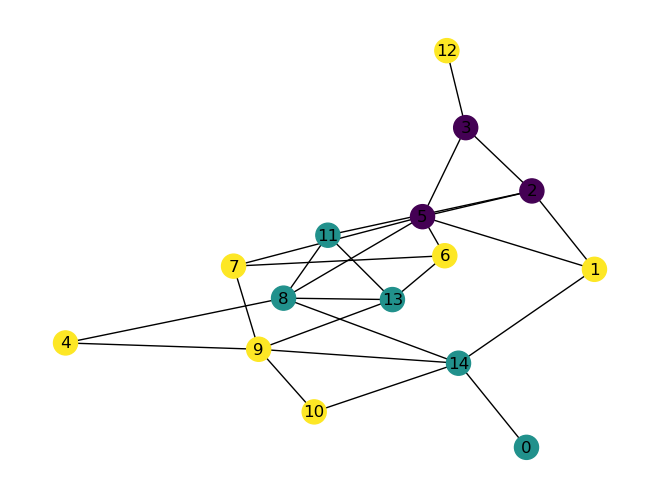

In [363]:
for _ in range(5) :
    simul.step()
print(nx.get_node_attributes(G, "opinion"))
draw(G)

MA for node 11 -> rule:1, neigh_removed:2, neigh_added:14
MA for node 14 -> rule:1, neigh_removed:10, neigh_added:13
MA for node 13 -> rule:1, neigh_removed:9, neigh_added:0
MP for node 8 -> prev_opinion:1, curr_opinion:1
MA for node 7 -> rule:1, neigh_removed:5, neigh_added:4
MA for node 4 -> rule:0, neigh_removed:8, neigh_added:1
MA for node 9 -> rule:0, neigh_removed:14, neigh_added:12
MA for node 1 -> rule:0, neigh_removed:14, neigh_added:6


1 12 3
{4: 2, 3: 1}


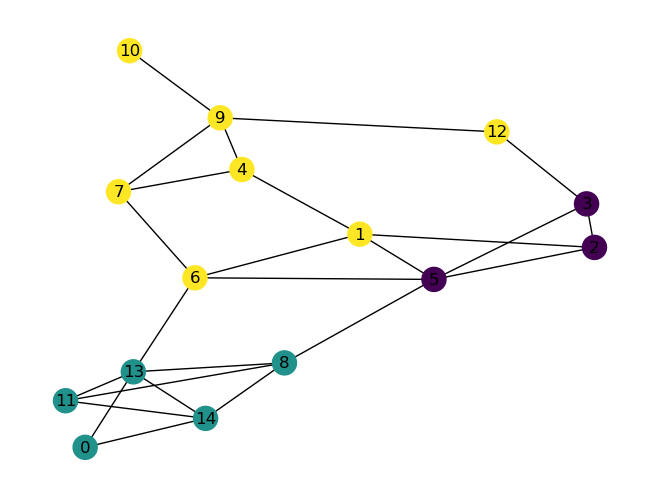

In [364]:
simul.run()
draw(G)
print(simul.status, simul.time, simul.stall)
print(simul.stall_bin)